In [1]:
#import packages
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor
import itertools    
from collections import Counter
import json
import seaborn as sns
import random
import torchvision.transforms as T



In [ ]:
#setup parameter configurations
class Config:
    def __init__(self):
        # Training parameters
        self.batch_size = 32
        self.num_epochs = 50
        self.learning_rate = 1e-5
        
        # Model parameters
        self.model_name = "openai/clip-vit-base-patch32"
        self.image_size = 224
        
        # Paths
        self.metadata_dir = "/Users/stellad/nutrition5k_dataset/metadata"
        self.image_dir = "/Users/stellad/nutrition5k_dataset/imagery/realsense_overhead"
        self.cafe1_path = os.path.join(self.metadata_dir, "dish_metadata_cafe1.csv")
        
        # Create model save directory
        self.model_dir = "model_checkpoints"
        os.makedirs(self.model_dir, exist_ok=True)
        self.save_path = os.path.join(self.model_dir, "food_clip_model.pt")

In [ ]:
#CLIP Model
class SimilarityFoodCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.temperature = 0.07
    
    def forward(self, images, text_inputs):
        # Get image features from CLIP
        image_features = self.get_image_features(images)
        
        if text_inputs is not None:
            # Get text features from CLIP
            text_features = self.get_text_features(text_inputs)
            return image_features, text_features
        
        return image_features
    
    def get_image_features(self, images):
        image_features = self.clip_model.get_image_features(images)
        return image_features / image_features.norm(dim=-1, keepdim=True)
    
    def get_text_features(self, text_inputs):
        text_features = self.clip_model.get_text_features(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask']
        )
        return text_features / text_features.norm(dim=-1, keepdim=True)


In [ ]:
#Data Pre-Processing
class NutritionDataset(Dataset):
    def __init__(self, metadata_df, processor):
        self.metadata = metadata_df
        self.processor = processor

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Load image
        try:
            image = Image.open(row["image_path"]).convert("RGB")
            # Process the image using CLIP processor
            processed_image = self.processor(
                images=image,
                return_tensors="pt",
                padding=True
            )["pixel_values"].squeeze(0)  # Remove batch dimension
        except Exception as e:
            print(f"Error loading image at index {idx}: {str(e)}")
            # Create a blank image with the correct dimensions
            processed_image = torch.zeros((3, 224, 224))
        
        return {
            "image": processed_image,
            "text": row["Description"]
        }
    
def create_data_loaders(train_df, val_df, test_df, processor, batch_size):
    """Create data loaders with CLIP processor"""
    train_dataset = NutritionDataset(train_df, processor)
    val_dataset = NutritionDataset(val_df, processor)
    test_dataset = NutritionDataset(test_df, processor)

    # Define a custom collate function
    def collate_fn(batch):
        images = torch.stack([item["image"] for item in batch])  # Stack images
        texts = [item["text"] for item in batch]  # Collect texts
        return {"images": images, "texts": texts}

    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=1, 
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

def prepare_dataset(config):
    """Prepare and split the dataset, removing rows with deprecated ingredients."""
    deprecated_ingredient_name = "deprecated"  # Define the deprecated ingredient name
    
    def get_max_columns(file_path):
        with open(file_path, 'r') as f:
            max_fields = max(len(line.strip().split(',')) for line in f)
        return max_fields

    def generate_column_names(max_fields):
        core_columns = ['dish_id', 'total_calories', 'total_mass', 'total_fat', 
                        'total_carb', 'total_protein']
        num_ingredients = (max_fields - len(core_columns)) // 7
        for i in range(1, num_ingredients + 1):
            core_columns.extend([
                f'ingr_{i}_id', f'ingr_{i}_name', f'ingr_{i}_grams',
                f'ingr_{i}_calories', f'ingr_{i}_fat', f'ingr_{i}_carb', 
                f'ingr_{i}_protein'
            ])
        return core_columns

    max_fields = get_max_columns(config.cafe1_path)
    column_names = generate_column_names(max_fields)
    df = pd.read_csv(config.cafe1_path, names=column_names, header=None, low_memory=False)

    processed_data = []
    ingredients_set = set()

    for idx, row in df.iterrows():
        try:
            ingredients = []
            for i in range(7, len(row), 7):
                if pd.notna(row.iloc[i]) and pd.notna(row.iloc[i + 1]):
                    ingredients.append((row.iloc[i], float(row.iloc[i + 1])))

            # Filter out rows with deprecated ingredients
            if any(name == deprecated_ingredient_name for name, _ in ingredients):
                continue  # Skip this row if it contains the deprecated ingredient

            if ingredients:
                highest_mass_ingredient = max(ingredients, key=lambda x: x[1])[0]
                ingredients_set.add(highest_mass_ingredient)
                macros = {
                    "fat": float(row['total_fat']),
                    "carbs": float(row['total_carb']),
                    "protein": float(row['total_protein'])
                }
                top_two = sorted(macros.items(), key=lambda x: x[1], reverse=True)[:2]
                description = f"This meal contains a lot of {highest_mass_ingredient} and is high in {top_two[0][0]} and {top_two[1][0]}."
                processed_data.append({
                    "dish_id": row['dish_id'],
                    "Description": description,
                    "image_path": os.path.join(config.image_dir, str(row['dish_id']), "rgb.png"),
                    "main_ingredient": highest_mass_ingredient,
                    "nutrient1": top_two[0][0],
                    "nutrient2": top_two[1][0]
                })
        except (ValueError, KeyError) as e:
            continue    

    
    combined_df = pd.DataFrame(processed_data)
    combined_df = combined_df[combined_df["image_path"].apply(os.path.exists)].reset_index(drop=True)
    
    # Create ingredient to index mapping
    unique_ingredients = sorted(combined_df["main_ingredient"].unique())
    ingredient_to_idx = {ingredient: idx for idx, ingredient in enumerate(unique_ingredients)}
    
    # Ensure the dataset contains exactly 1000 samples
    if len(combined_df) < 1000:
        raise ValueError(f"Not enough valid data points. Found {len(combined_df)}, need 1000 after cleaning.")
    if len(combined_df) > 1000:
        combined_df = combined_df.sample(n=1000, random_state=42).reset_index(drop=True)

    # Split into train (800), val (100), and test (100)
    train_df = combined_df.iloc[:800].reset_index(drop=True)
    val_df = combined_df.iloc[800:900].reset_index(drop=True)
    test_df = combined_df.iloc[900:1000].reset_index(drop=True)
    
    print(f"Dataset splits:")
    print(f"Train set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    print(f"Number of unique ingredients: {len(ingredient_to_idx)}")

    nutrient_names = ['fat', 'carbs', 'protein']
    all_possible_descriptions = []
    for ingredient in unique_ingredients:
        for n1 in nutrient_names:
            for n2 in nutrient_names:
                if n1 != n2:  # Avoid duplicate nutrient pairs
                    description = f"This meal contains a lot of {ingredient} and is high in {n1} and {n2}."
                    all_possible_descriptions.append(description)


    

    return train_df, val_df, test_df, all_possible_descriptions
            


In [ ]:

def evaluate_model(model, test_loader, processor, device):
    """Evaluate model with detailed metrics"""
    model.eval()
    test_metrics = {'ingredient_accuracy': 0, 'nutrient_accuracy': 0, 'overall_accuracy': 0}
    
    # Load model checkpoint to get all possible descriptions
    checkpoint = torch.load(config.save_path)
    all_possible_descriptions = checkpoint['all_possible_descriptions']
    
    # Process all possible descriptions
    text_inputs = processor(
        text=all_possible_descriptions,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    # Track predictions and metrics
    all_predictions = []
    all_actuals = []
    test_loss = 0
    test_batches = 0
    
    # Initialize mistake tracking
    ingredient_mistakes = []  # Will store tuples of (actual, predicted)
    nutrient_mistakes = []    # Will store tuples of (tuple(actual), tuple(predicted))
    
    with torch.no_grad():
        # Get text features for all descriptions
        all_text_features = model.get_text_features(text_inputs)
        
        for batch in tqdm(test_loader, desc="Testing"):
            images = batch["images"].to(device)
            actual_texts = batch["texts"]
            
            # Get image features
            image_features = model.get_image_features(images)
            
            # Calculate logits against all possible descriptions
            logits = (image_features @ all_text_features.T) / model.temperature
            
            # Get predictions
            pred_indices = logits.argmax(dim=1).cpu()
            predicted_texts = [all_possible_descriptions[idx] for idx in pred_indices]
            
            # Store for analysis
            all_predictions.extend(predicted_texts)
            all_actuals.extend(actual_texts)
            
            # Calculate loss
            correct_indices = torch.tensor([
                all_possible_descriptions.index(text) for text in actual_texts
            ]).to(device)
            loss = F.cross_entropy(logits, correct_indices)
            test_loss += loss.item()
            test_batches += 1
    
    # Calculate metrics
    total = len(all_predictions)
    ingredient_correct = 0
    nutrient_correct = 0
    
    for pred, actual in zip(all_predictions, all_actuals):
        # Extract ingredients
        pred_ingredient = pred.split(" and is high in ")[0].replace("This meal contains a lot of ", "")
        actual_ingredient = actual.split(" and is high in ")[0].replace("This meal contains a lot of ", "")
        
        # Compare ingredients
        if pred_ingredient == actual_ingredient:
            ingredient_correct += 1
        else:
            ingredient_mistakes.append((actual_ingredient, pred_ingredient))
        
        # Extract and compare nutrients (order-invariant)
        try:
            pred_nutrients = tuple(sorted(
                pred.split(" and is high in ")[1].replace(".", "").split(" and ")
            ))
            actual_nutrients = tuple(sorted(
                actual.split(" and is high in ")[1].replace(".", "").split(" and ")
            ))
            
            if pred_nutrients == actual_nutrients:
                nutrient_correct += 1
            else:
                # Store as tuples to make them hashable
                nutrient_mistakes.append((actual_nutrients, pred_nutrients))
        except IndexError as e:
            print(f"Warning: Malformed text format:\nPred: {pred}\nActual: {actual}\nError: {str(e)}")
            continue
    
    # Calculate final metrics
    test_metrics['ingredient_accuracy'] = ingredient_correct / total
    test_metrics['nutrient_accuracy'] = nutrient_correct / total
    test_metrics['overall_accuracy'] = (ingredient_correct + nutrient_correct) / (2 * total)
    test_metrics['loss'] = test_loss / test_batches
    
    # Print detailed results
    print("\nTest Results:")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Ingredient Accuracy: {test_metrics['ingredient_accuracy']:.4f}")
    print(f"Nutrient Accuracy: {test_metrics['nutrient_accuracy']:.4f}")
    print(f"Overall Accuracy: {test_metrics['overall_accuracy']:.4f}")
    
    # Print error analysis
    if ingredient_mistakes:
        print("\nTop 5 Ingredient Mistakes:")
        ingredient_error_counts = Counter(ingredient_mistakes)
        for (actual, pred), count in ingredient_error_counts.most_common(5):
            print(f"Actual: {actual}, Predicted: {pred}, Count: {count}")
            print(f"Error Rate: {count/total:.2%}")
    
    if nutrient_mistakes:
        print("\nTop 5 Nutrient Pair Mistakes:")
        # nutrient_mistakes already contains tuples
        nutrient_error_counts = Counter(nutrient_mistakes)
        for (actual, pred), count in nutrient_error_counts.most_common(5):
            print(f"Actual: {' and '.join(actual)}, Predicted: {' and '.join(pred)}, Count: {count}")
            print(f"Error Rate: {count/total:.2%}")
    
    # Save detailed analysis
    analysis_results = {
        'metrics': test_metrics,
        'ingredient_mistakes': [{'actual': a, 'predicted': p} for a, p in ingredient_mistakes],
        'nutrient_mistakes': [{
            'actual': list(a), 
            'predicted': list(p)
        } for a, p in nutrient_mistakes],
        'total_samples': total
    }
    
    try:
        with open('test_analysis.json', 'w') as f:
            json.dump(analysis_results, f, indent=2)
        print("\nDetailed analysis saved to test_analysis.json")
    except Exception as e:
        print(f"\nWarning: Could not save analysis to file: {str(e)}")
    
    return test_metrics, (ingredient_mistakes, nutrient_mistakes)
       
def calculate_batch_accuracy(predicted_texts, actual_texts, all_possible_texts=None):
    """Calculate ingredient and nutrient accuracy for a batch"""
    total = len(predicted_texts)
    ingredient_correct = 0
    nutrient_correct = 0
    
    # For detailed tracking
    ingredient_mistakes = []
    nutrient_mistakes = []
    
    for pred, actual in zip(predicted_texts, actual_texts):
        # Extract ingredients
        pred_ingredient = pred.split(" and is high in ")[0].replace("This meal contains a lot of ", "")
        actual_ingredient = actual.split(" and is high in ")[0].replace("This meal contains a lot of ", "")
        
        # Compare ingredients
        if pred_ingredient == actual_ingredient:
            ingredient_correct += 1
        else:
            ingredient_mistakes.append((actual_ingredient, pred_ingredient))
        
        # Extract and compare nutrients (order-invariant)
        try:
            pred_nutrients = set(pred.split(" and is high in ")[1].replace(".", "").split(" and "))
            actual_nutrients = set(actual.split(" and is high in ")[1].replace(".", "").split(" and "))
            
            if pred_nutrients == actual_nutrients:
                nutrient_correct += 1
            else:
                nutrient_mistakes.append((actual_nutrients, pred_nutrients))
        except IndexError:
            print(f"Warning: Malformed prediction or actual text:\nPred: {pred}\nActual: {actual}")
            continue
    
    metrics = {
        'ingredient_accuracy': ingredient_correct / total,
        'nutrient_accuracy': nutrient_correct / total,
        'overall_accuracy': (ingredient_correct + nutrient_correct) / (2 * total),
        'ingredient_mistakes': ingredient_mistakes,
        'nutrient_mistakes': nutrient_mistakes
    }
    
    return metrics

def plot_training_curves(metrics):
    """Plot training and validation curves for all metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot loss
    axes[0, 0].plot(metrics['train_losses'], label='Train Loss')
    axes[0, 0].plot(metrics['val_losses'], label='Val Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Plot ingredient accuracy
    axes[0, 1].plot(metrics['train_ingr_acc'], label='Train Ingredient Acc')
    axes[0, 1].plot(metrics['val_ingr_acc'], label='Val Ingredient Acc')
    axes[0, 1].set_title('Ingredient Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Plot nutrient accuracy
    axes[1, 0].plot(metrics['train_nutr_acc'], label='Train Nutrient Acc')
    axes[1, 0].plot(metrics['val_nutr_acc'], label='Val Nutrient Acc')
    axes[1, 0].set_title('Nutrient Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    
    # Plot overall accuracy
    axes[1, 1].plot(metrics['train_overall_acc'], label='Train Overall Acc')
    axes[1, 1].plot(metrics['val_overall_acc'], label='Val Overall Acc')
    axes[1, 1].set_title('Overall Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_loader, processor, device, num_examples=5):
    """Visualize random model predictions showing full sentences"""
    model.eval()
    
    # Load all possible descriptions
    checkpoint = torch.load(config.save_path, weights_only=True)
    all_descriptions = checkpoint['all_possible_descriptions']
    
    # Process all descriptions once
    text_inputs = processor(
        text=all_descriptions,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    # Collect all test samples first
    all_samples = []
    with torch.no_grad():
        for batch in test_loader:
            all_samples.append(batch)
    
    # Randomly sample num_examples
    selected_samples = random.sample(all_samples, min(num_examples, len(all_samples)))
    
    plt.figure(figsize=(20, 6*num_examples))
    
    with torch.no_grad():
        # Get text features for all descriptions
        all_text_features = model.get_text_features(text_inputs)
        
        for i, batch in enumerate(selected_samples):
            # Get images and actual texts
            images = batch["images"].to(device)
            actual_text = batch["texts"][0]
            
            # Get image features and compute similarities
            image_features = model.get_image_features(images)
            similarities = (100.0 * image_features @ all_text_features.T).squeeze()
            
            # Get top 3 predictions
            top_k = 3
            top_indices = similarities.topk(top_k).indices.cpu().numpy()
            top_scores = similarities.topk(top_k).values.cpu().numpy()
            
            # Display image
            plt.subplot(num_examples, 2, 2*i + 1)
            img_display = images[0].permute(1, 2, 0).cpu().numpy()
            
            # Denormalize image
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            plt.imshow(img_display)
            plt.axis('off')
            plt.title('Input Image', pad=20)
            
            # Display predictions
            plt.subplot(num_examples, 2, 2*i + 2)
            plt.axis('off')
            
            # Format text output
            text = "Ground Truth:\n"
            text += f"{actual_text}\n\n"
            text += "Top 3 Predictions:\n"
            
            for idx, (pred_idx, score) in enumerate(zip(top_indices, top_scores)):
                pred_text = all_descriptions[pred_idx]
                text += f"\n{idx+1}. ({score:.1f}%)\n{pred_text}"
                
                # Add match indicator if exact match
                if pred_text == actual_text:
                    text += "\n✓ EXACT MATCH"
                text += "\n"
            
            plt.text(0.05, 0.5, text, fontsize=12, wrap=True, verticalalignment='center')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    




In [2]:
def train_model_with_early_stopping(epochs, batch_size, patience=10):
    config = Config()
    
    # Device setup
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Using device: {device}")

    # Model setup
    clip_model = CLIPModel.from_pretrained(config.model_name)
    processor = CLIPProcessor.from_pretrained(config.model_name)
    model = SimilarityFoodCLIPModel(clip_model).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
    
    # Data setup
    train_df, val_df, test_df, all_possible_descriptions = prepare_dataset(config)
    train_loader, val_loader, test_loader = create_data_loaders(
        train_df, val_df, test_df, processor, batch_size
    )

    text_inputs = processor(
        text=all_possible_descriptions,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    # Training tracking
    best_val_loss = float('inf')
    metrics = {
        'train_losses': [], 'val_losses': [],
        'train_ingr_acc': [], 'val_ingr_acc': [],
        'train_nutr_acc': [], 'val_nutr_acc': [],
        'train_overall_acc': [], 'val_overall_acc': []
    }
    no_improvement_epochs = 0  # Counter for early stopping

    try:
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            
            # Training
            model.train()
            train_loss = 0
            epoch_train_metrics = {'ingredient_accuracy': 0, 'nutrient_accuracy': 0, 'overall_accuracy': 0}
            train_batches = 0

            with torch.no_grad():
                all_text_features = model.get_text_features(text_inputs)
            
            for batch in train_loader:
                images = batch["images"].to(device)
                actual_texts = batch["texts"]

                image_features = model.get_image_features(images)
        
                # Calculate similarities and loss
                logits = (image_features @ all_text_features.T) / model.temperature
                correct_indices = torch.tensor([
                    all_possible_descriptions.index(text) for text in actual_texts
                ]).to(device)
                loss = F.cross_entropy(logits, correct_indices)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                # Calculate accuracy
                with torch.no_grad():
                    pred_indices = logits.argmax(dim=1).cpu()
                    predicted_texts = [all_possible_descriptions[idx] for idx in pred_indices]
                    batch_metrics = calculate_batch_accuracy(predicted_texts, actual_texts)
                    for key in epoch_train_metrics:
                        epoch_train_metrics[key] += batch_metrics[key]
                    train_batches += 1
            
            # Calculate epoch metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_train_metrics = {k: v / train_batches for k, v in epoch_train_metrics.items()}
            
            # Validation
            model.eval()
            val_loss = 0
            epoch_val_metrics = {'ingredient_accuracy': 0, 'nutrient_accuracy': 0, 'overall_accuracy': 0}
            val_batches = 0
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    images = batch["images"].to(device)
                    actual_texts = batch["texts"]
                    
                    image_features = model.get_image_features(images)
                    logits = (image_features @ all_text_features.T) / model.temperature
                    correct_indices = torch.tensor([
                        all_possible_descriptions.index(text) for text in actual_texts
                    ]).to(device)
                    loss = F.cross_entropy(logits, correct_indices)
                    val_loss += loss.item()
                    
                    # Calculate accuracy
                    pred_indices = logits.argmax(dim=1).cpu()
                    predicted_texts = [all_possible_descriptions[idx] for idx in pred_indices]
                    batch_metrics = calculate_batch_accuracy(predicted_texts, actual_texts)
                    for key in epoch_val_metrics:
                        epoch_val_metrics[key] += batch_metrics[key]
                    val_batches += 1
            
            avg_val_loss = val_loss / len(val_loader)
            avg_val_metrics = {k: v / val_batches for k, v in epoch_val_metrics.items()}
            
            # Update metrics tracking
            metrics['train_losses'].append(avg_train_loss)
            metrics['val_losses'].append(avg_val_loss)
            metrics['train_ingr_acc'].append(avg_train_metrics['ingredient_accuracy'])
            metrics['val_ingr_acc'].append(avg_val_metrics['ingredient_accuracy'])
            metrics['train_nutr_acc'].append(avg_train_metrics['nutrient_accuracy'])
            metrics['val_nutr_acc'].append(avg_val_metrics['nutrient_accuracy'])
            metrics['train_overall_acc'].append(avg_train_metrics['overall_accuracy'])
            metrics['val_overall_acc'].append(avg_val_metrics['overall_accuracy'])
            
            # Print epoch metrics
            print(f"\nEpoch {epoch+1} Results:")
            print(f"Train - Loss: {avg_train_loss:.4f}")
            print(f"Train - Ingredient Acc: {avg_train_metrics['ingredient_accuracy']:.4f}")
            print(f"Train - Nutrient Acc: {avg_train_metrics['nutrient_accuracy']:.4f}")
            print(f"Train - Overall Acc: {avg_train_metrics['overall_accuracy']:.4f}")
            print(f"Val - Loss: {avg_val_loss:.4f}")
            print(f"Val - Ingredient Acc: {avg_val_metrics['ingredient_accuracy']:.4f}")
            print(f"Val - Nutrient Acc: {avg_val_metrics['nutrient_accuracy']:.4f}")
            print(f"Val - Overall Acc: {avg_val_metrics['overall_accuracy']:.4f}")
            
            # Early stopping logic
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement_epochs = 0
                try:
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch,
                        'best_val_loss': best_val_loss,
                        'metrics': metrics,
                        'all_possible_descriptions': all_possible_descriptions
                    }, config.save_path)
                    print(f"Saved best model to {config.save_path}")
                except Exception as e:
                    print(f"Warning: Could not save model checkpoint: {str(e)}")
            else:
                
                no_improvement_epochs += 1
                print(f"No improvement in validation loss for {no_improvement_epochs} epoch(s).")
                if no_improvement_epochs >= patience:
                    print(f"Early stopping triggered. Best validation loss: {best_val_loss:.4f}")
                    break
                                
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"\nError during training: {str(e)}")
    finally:
        if len(metrics['train_losses']) > 0:
            plot_training_curves(metrics)
                
    return model, processor, metrics


Using device: mps
Dataset splits:
Train set: 800 samples
Validation set: 100 samples
Test set: 100 samples
Number of unique ingredients: 117

Epoch 1/50


Validation:   0%|          | 0/4 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]



Epoch 1 Results:
Train - Loss: 5.4024
Train - Ingredient Acc: 0.4088
Train - Nutrient Acc: 0.4025
Train - Overall Acc: 0.4056
Val - Loss: 4.9356
Val - Ingredient Acc: 0.5312
Val - Nutrient Acc: 0.5078
Val - Overall Acc: 0.5195
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 2/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]



Epoch 2 Results:
Train - Loss: 4.5165
Train - Ingredient Acc: 0.6250
Train - Nutrient Acc: 0.4188
Train - Overall Acc: 0.5219
Val - Loss: 4.6311
Val - Ingredient Acc: 0.5547
Val - Nutrient Acc: 0.5391
Val - Overall Acc: 0.5469
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 3/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]



Epoch 3 Results:
Train - Loss: 4.0022
Train - Ingredient Acc: 0.7275
Train - Nutrient Acc: 0.3500
Train - Overall Acc: 0.5387
Val - Loss: 4.4681
Val - Ingredient Acc: 0.5781
Val - Nutrient Acc: 0.5078
Val - Overall Acc: 0.5430
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 4/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 4 Results:
Train - Loss: 3.6553
Train - Ingredient Acc: 0.7950
Train - Nutrient Acc: 0.3762
Train - Overall Acc: 0.5856
Val - Loss: 4.3770
Val - Ingredient Acc: 0.5781
Val - Nutrient Acc: 0.4922
Val - Overall Acc: 0.5352
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 5/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



Epoch 5 Results:
Train - Loss: 3.4519
Train - Ingredient Acc: 0.8375
Train - Nutrient Acc: 0.3787
Train - Overall Acc: 0.6081
Val - Loss: 4.2964
Val - Ingredient Acc: 0.5938
Val - Nutrient Acc: 0.5000
Val - Overall Acc: 0.5469
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 6/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]



Epoch 6 Results:
Train - Loss: 3.3222
Train - Ingredient Acc: 0.8500
Train - Nutrient Acc: 0.3738
Train - Overall Acc: 0.6119
Val - Loss: 4.2597
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.5000
Val - Overall Acc: 0.5742
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 7/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 7 Results:
Train - Loss: 3.2276
Train - Ingredient Acc: 0.8688
Train - Nutrient Acc: 0.3862
Train - Overall Acc: 0.6275
Val - Loss: 4.2188
Val - Ingredient Acc: 0.6328
Val - Nutrient Acc: 0.5391
Val - Overall Acc: 0.5859
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 8/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]



Epoch 8 Results:
Train - Loss: 3.1568
Train - Ingredient Acc: 0.8850
Train - Nutrient Acc: 0.4012
Train - Overall Acc: 0.6431
Val - Loss: 4.2086
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5234
Val - Overall Acc: 0.5938
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 9/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Epoch 9 Results:
Train - Loss: 3.0962
Train - Ingredient Acc: 0.8988
Train - Nutrient Acc: 0.4113
Train - Overall Acc: 0.6550
Val - Loss: 4.1513
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.5391
Val - Overall Acc: 0.5703
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 10/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 10 Results:
Train - Loss: 3.0536
Train - Ingredient Acc: 0.9163
Train - Nutrient Acc: 0.4412
Train - Overall Acc: 0.6787
Val - Loss: 4.1344
Val - Ingredient Acc: 0.6719
Val - Nutrient Acc: 0.5469
Val - Overall Acc: 0.6094
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 11/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



Epoch 11 Results:
Train - Loss: 3.0147
Train - Ingredient Acc: 0.9437
Train - Nutrient Acc: 0.4462
Train - Overall Acc: 0.6950
Val - Loss: 4.1446
Val - Ingredient Acc: 0.6250
Val - Nutrient Acc: 0.5156
Val - Overall Acc: 0.5703
No improvement in validation loss for 1 epoch(s).

Epoch 12/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]



Epoch 12 Results:
Train - Loss: 2.9873
Train - Ingredient Acc: 0.9475
Train - Nutrient Acc: 0.4612
Train - Overall Acc: 0.7044
Val - Loss: 4.1479
Val - Ingredient Acc: 0.6172
Val - Nutrient Acc: 0.5391
Val - Overall Acc: 0.5781
No improvement in validation loss for 2 epoch(s).

Epoch 13/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]



Epoch 13 Results:
Train - Loss: 2.9559
Train - Ingredient Acc: 0.9587
Train - Nutrient Acc: 0.4675
Train - Overall Acc: 0.7131
Val - Loss: 4.1241
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5469
Val - Overall Acc: 0.6055
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 14/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



Epoch 14 Results:
Train - Loss: 2.9284
Train - Ingredient Acc: 0.9712
Train - Nutrient Acc: 0.4763
Train - Overall Acc: 0.7238
Val - Loss: 4.1292
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5625
Val - Overall Acc: 0.6133
No improvement in validation loss for 1 epoch(s).

Epoch 15/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Epoch 15 Results:
Train - Loss: 2.9101
Train - Ingredient Acc: 0.9788
Train - Nutrient Acc: 0.5000
Train - Overall Acc: 0.7394
Val - Loss: 4.0692
Val - Ingredient Acc: 0.6797
Val - Nutrient Acc: 0.6250
Val - Overall Acc: 0.6523
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 16/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 16 Results:
Train - Loss: 2.8864
Train - Ingredient Acc: 0.9788
Train - Nutrient Acc: 0.5275
Train - Overall Acc: 0.7531
Val - Loss: 4.0721
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.6484
Val - Overall Acc: 0.6562
No improvement in validation loss for 1 epoch(s).

Epoch 17/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Epoch 17 Results:
Train - Loss: 2.8660
Train - Ingredient Acc: 0.9788
Train - Nutrient Acc: 0.5262
Train - Overall Acc: 0.7525
Val - Loss: 4.1099
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.5703
Val - Overall Acc: 0.6133
No improvement in validation loss for 2 epoch(s).

Epoch 18/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Epoch 18 Results:
Train - Loss: 2.8507
Train - Ingredient Acc: 0.9862
Train - Nutrient Acc: 0.5487
Train - Overall Acc: 0.7675
Val - Loss: 4.0855
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.6719
Val - Overall Acc: 0.6367
No improvement in validation loss for 3 epoch(s).

Epoch 19/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Epoch 19 Results:
Train - Loss: 2.8378
Train - Ingredient Acc: 0.9838
Train - Nutrient Acc: 0.5737
Train - Overall Acc: 0.7788
Val - Loss: 4.0741
Val - Ingredient Acc: 0.5938
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.5859
No improvement in validation loss for 4 epoch(s).

Epoch 20/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]



Epoch 20 Results:
Train - Loss: 2.8270
Train - Ingredient Acc: 0.9888
Train - Nutrient Acc: 0.5700
Train - Overall Acc: 0.7794
Val - Loss: 4.0488
Val - Ingredient Acc: 0.6719
Val - Nutrient Acc: 0.6797
Val - Overall Acc: 0.6758
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 21/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 21 Results:
Train - Loss: 2.8172
Train - Ingredient Acc: 0.9862
Train - Nutrient Acc: 0.5938
Train - Overall Acc: 0.7900
Val - Loss: 4.0570
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5938
Val - Overall Acc: 0.6289
No improvement in validation loss for 1 epoch(s).

Epoch 22/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 22 Results:
Train - Loss: 2.8140
Train - Ingredient Acc: 0.9888
Train - Nutrient Acc: 0.5913
Train - Overall Acc: 0.7900
Val - Loss: 4.0513
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.6172
No improvement in validation loss for 2 epoch(s).

Epoch 23/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]



Epoch 23 Results:
Train - Loss: 2.8074
Train - Ingredient Acc: 0.9938
Train - Nutrient Acc: 0.5913
Train - Overall Acc: 0.7925
Val - Loss: 4.0461
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6797
Val - Overall Acc: 0.6680
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 24/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



Epoch 24 Results:
Train - Loss: 2.7987
Train - Ingredient Acc: 0.9950
Train - Nutrient Acc: 0.6050
Train - Overall Acc: 0.8000
Val - Loss: 4.0870
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6562
No improvement in validation loss for 1 epoch(s).

Epoch 25/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



Epoch 25 Results:
Train - Loss: 2.7929
Train - Ingredient Acc: 0.9975
Train - Nutrient Acc: 0.6162
Train - Overall Acc: 0.8069
Val - Loss: 4.0456
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6602
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 26/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 26 Results:
Train - Loss: 2.7881
Train - Ingredient Acc: 0.9962
Train - Nutrient Acc: 0.6212
Train - Overall Acc: 0.8087
Val - Loss: 4.0425
Val - Ingredient Acc: 0.6406
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6523
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 27/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]



Epoch 27 Results:
Train - Loss: 2.7830
Train - Ingredient Acc: 0.9988
Train - Nutrient Acc: 0.6250
Train - Overall Acc: 0.8119
Val - Loss: 4.0369
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6875
Val - Overall Acc: 0.6719
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 28/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 28 Results:
Train - Loss: 2.7776
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6388
Train - Overall Acc: 0.8194
Val - Loss: 4.0285
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6562
Val - Overall Acc: 0.6562
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 29/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]



Epoch 29 Results:
Train - Loss: 2.7727
Train - Ingredient Acc: 0.9962
Train - Nutrient Acc: 0.6375
Train - Overall Acc: 0.8169
Val - Loss: 4.0069
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6562
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 30/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 30 Results:
Train - Loss: 2.7722
Train - Ingredient Acc: 0.9988
Train - Nutrient Acc: 0.6462
Train - Overall Acc: 0.8225
Val - Loss: 4.0074
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6875
Val - Overall Acc: 0.6719
No improvement in validation loss for 1 epoch(s).

Epoch 31/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]



Epoch 31 Results:
Train - Loss: 2.7703
Train - Ingredient Acc: 0.9988
Train - Nutrient Acc: 0.6250
Train - Overall Acc: 0.8119
Val - Loss: 4.0188
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6953
Val - Overall Acc: 0.6758
No improvement in validation loss for 2 epoch(s).

Epoch 32/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 32 Results:
Train - Loss: 2.7677
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6475
Train - Overall Acc: 0.8237
Val - Loss: 4.0000
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6562
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 33/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



Epoch 33 Results:
Train - Loss: 2.7650
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6350
Train - Overall Acc: 0.8175
Val - Loss: 4.0256
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6562
No improvement in validation loss for 1 epoch(s).

Epoch 34/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



Epoch 34 Results:
Train - Loss: 2.7613
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6525
Train - Overall Acc: 0.8263
Val - Loss: 3.9989
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6719
Val - Overall Acc: 0.6602
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 35/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]



Epoch 35 Results:
Train - Loss: 2.7574
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6538
Train - Overall Acc: 0.8269
Val - Loss: 4.0047
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6406
Val - Overall Acc: 0.6445
No improvement in validation loss for 1 epoch(s).

Epoch 36/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]



Epoch 36 Results:
Train - Loss: 2.7545
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6587
Train - Overall Acc: 0.8294
Val - Loss: 4.0025
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6953
Val - Overall Acc: 0.6719
No improvement in validation loss for 2 epoch(s).

Epoch 37/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]



Epoch 37 Results:
Train - Loss: 2.7517
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6613
Train - Overall Acc: 0.8306
Val - Loss: 3.9985
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6875
Val - Overall Acc: 0.6680
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 38/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 38 Results:
Train - Loss: 2.7506
Train - Ingredient Acc: 0.9988
Train - Nutrient Acc: 0.6625
Train - Overall Acc: 0.8306
Val - Loss: 3.9818
Val - Ingredient Acc: 0.6406
Val - Nutrient Acc: 0.6719
Val - Overall Acc: 0.6562
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 39/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]



Epoch 39 Results:
Train - Loss: 2.7496
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6663
Train - Overall Acc: 0.8331
Val - Loss: 3.9792
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6250
Val - Overall Acc: 0.6406
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 40/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 40 Results:
Train - Loss: 2.7491
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6637
Train - Overall Acc: 0.8319
Val - Loss: 3.9832
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6562
Val - Overall Acc: 0.6523
No improvement in validation loss for 1 epoch(s).

Epoch 41/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Epoch 41 Results:
Train - Loss: 2.7473
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6550
Train - Overall Acc: 0.8275
Val - Loss: 3.9917
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6719
Val - Overall Acc: 0.6641
No improvement in validation loss for 2 epoch(s).

Epoch 42/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Epoch 42 Results:
Train - Loss: 2.7465
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6663
Train - Overall Acc: 0.8331
Val - Loss: 3.9584
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.6484
Val - Overall Acc: 0.6523
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 43/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]



Epoch 43 Results:
Train - Loss: 2.7460
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6575
Train - Overall Acc: 0.8287
Val - Loss: 4.0111
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6719
Val - Overall Acc: 0.6602
No improvement in validation loss for 1 epoch(s).

Epoch 44/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 44 Results:
Train - Loss: 2.7441
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6550
Train - Overall Acc: 0.8275
Val - Loss: 3.9991
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6484
Val - Overall Acc: 0.6484
No improvement in validation loss for 2 epoch(s).

Epoch 45/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]



Epoch 45 Results:
Train - Loss: 2.7436
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6613
Train - Overall Acc: 0.8306
Val - Loss: 3.9845
Val - Ingredient Acc: 0.6406
Val - Nutrient Acc: 0.6641
Val - Overall Acc: 0.6523
No improvement in validation loss for 3 epoch(s).

Epoch 46/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 46 Results:
Train - Loss: 2.7431
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6637
Train - Overall Acc: 0.8319
Val - Loss: 3.9966
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6328
Val - Overall Acc: 0.6406
No improvement in validation loss for 4 epoch(s).

Epoch 47/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]



Epoch 47 Results:
Train - Loss: 2.7416
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6587
Train - Overall Acc: 0.8294
Val - Loss: 3.9608
Val - Ingredient Acc: 0.6406
Val - Nutrient Acc: 0.6562
Val - Overall Acc: 0.6484
No improvement in validation loss for 5 epoch(s).

Epoch 48/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]



Epoch 48 Results:
Train - Loss: 2.7411
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6550
Train - Overall Acc: 0.8275
Val - Loss: 3.9841
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6875
Val - Overall Acc: 0.6680
No improvement in validation loss for 6 epoch(s).

Epoch 49/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



Epoch 49 Results:
Train - Loss: 2.7407
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6700
Train - Overall Acc: 0.8350
Val - Loss: 3.9482
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6797
Val - Overall Acc: 0.6641
Saved best model to model_checkpoints/food_clip_model.pt

Epoch 50/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]



Epoch 50 Results:
Train - Loss: 2.7388
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6538
Train - Overall Acc: 0.8269
Val - Loss: 3.9721
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.6953
Val - Overall Acc: 0.6719
No improvement in validation loss for 1 epoch(s).


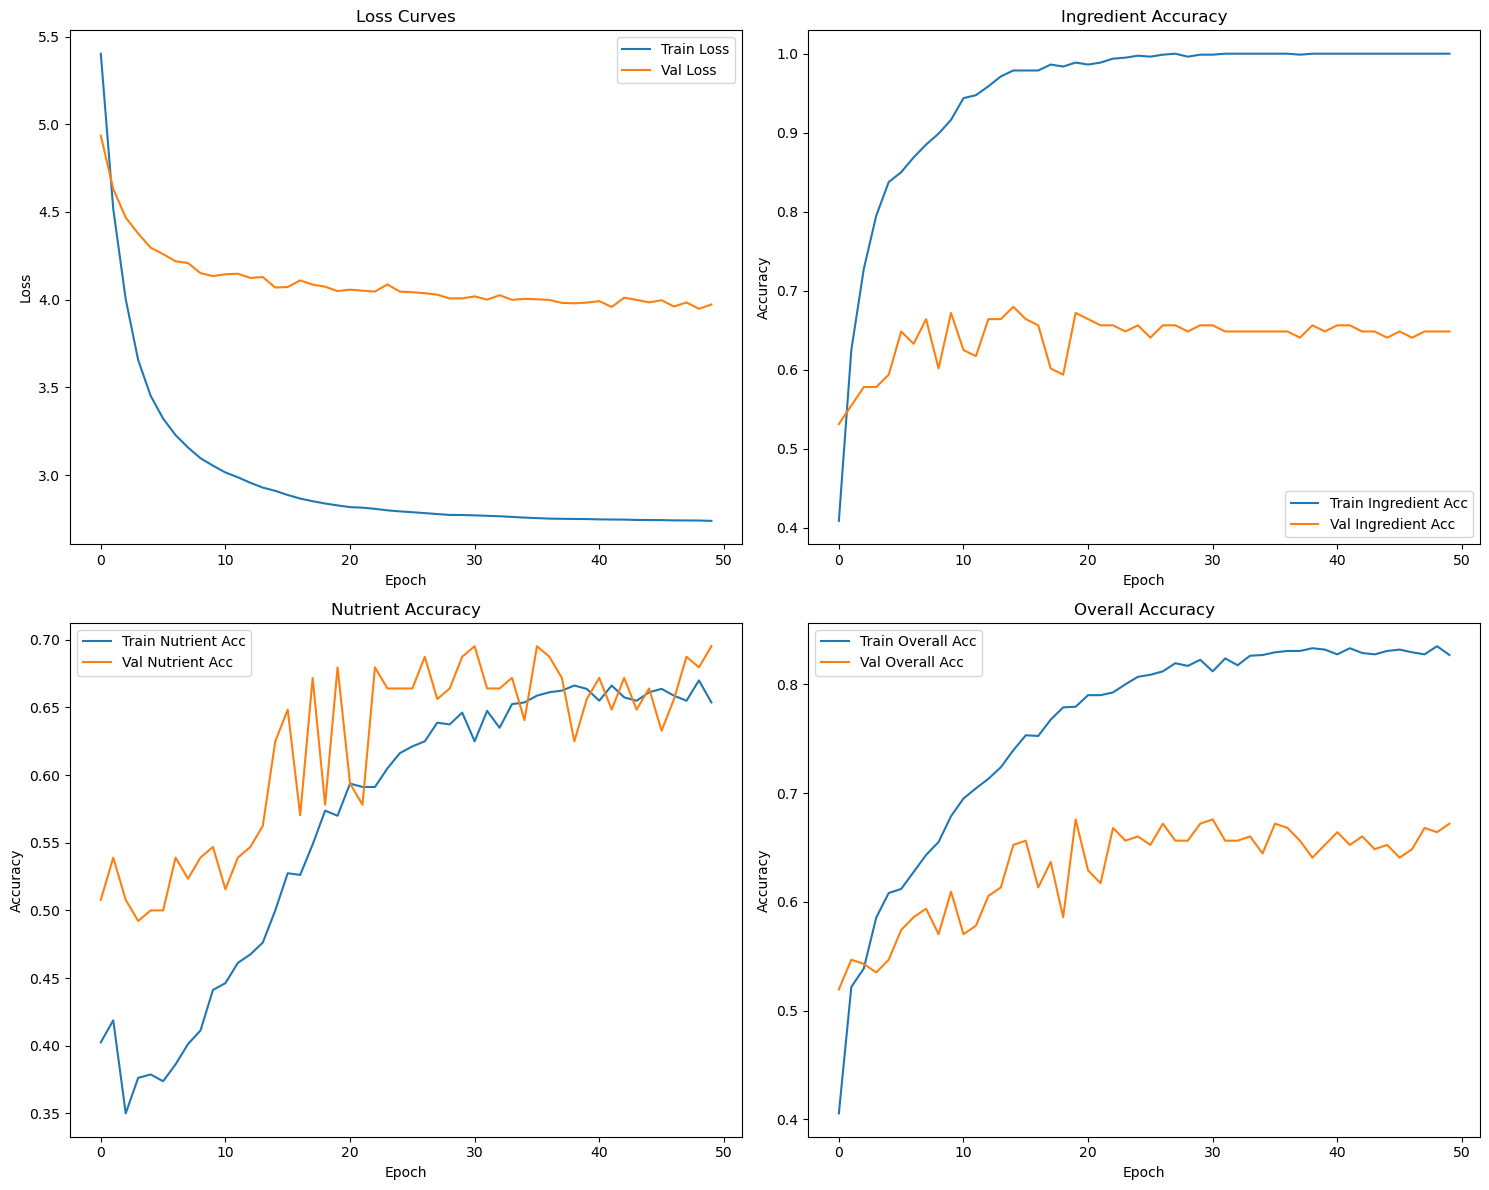

Dataset splits:
Train set: 800 samples
Validation set: 100 samples
Test set: 100 samples
Number of unique ingredients: 117


/var/folders/fk/gj43ql8172g1p_322ps4bc440000gn/T/ipykernel_30895/2626997339.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.save_path)
T


Test Results:
Test Loss: 4.0520
Ingredient Accuracy: 0.6000
Nutrient Accuracy: 0.5100
Overall Accuracy: 0.5550

Top 5 Ingredient Mistakes:
Actual: fish, Predicted: grilled chicken, Count: 2
Error Rate: 2.00%
Actual: sweet potato, Predicted: roasted potatoes, Count: 2
Error Rate: 2.00%
Actual: chicken, Predicted: pork, Count: 1
Error Rate: 1.00%
Actual: chicken breast, Predicted: salmon, Count: 1
Error Rate: 1.00%
Actual: mixed greens, Predicted: kale, Count: 1
Error Rate: 1.00%

Top 5 Nutrient Pair Mistakes:
Actual: carbs and protein, Predicted: fat and protein, Count: 28
Error Rate: 28.00%
Actual: carbs and fat, Predicted: fat and protein, Count: 7
Error Rate: 7.00%
Actual: carbs and protein, Predicted: carbs and fat, Count: 6
Error Rate: 6.00%
Actual: carbs and fat, Predicted: carbs and protein, Count: 4
Error Rate: 4.00%
Actual: fat and protein, Predicted: carbs and protein, Count: 3
Error Rate: 3.00%

Detailed analysis saved to test_analysis.json


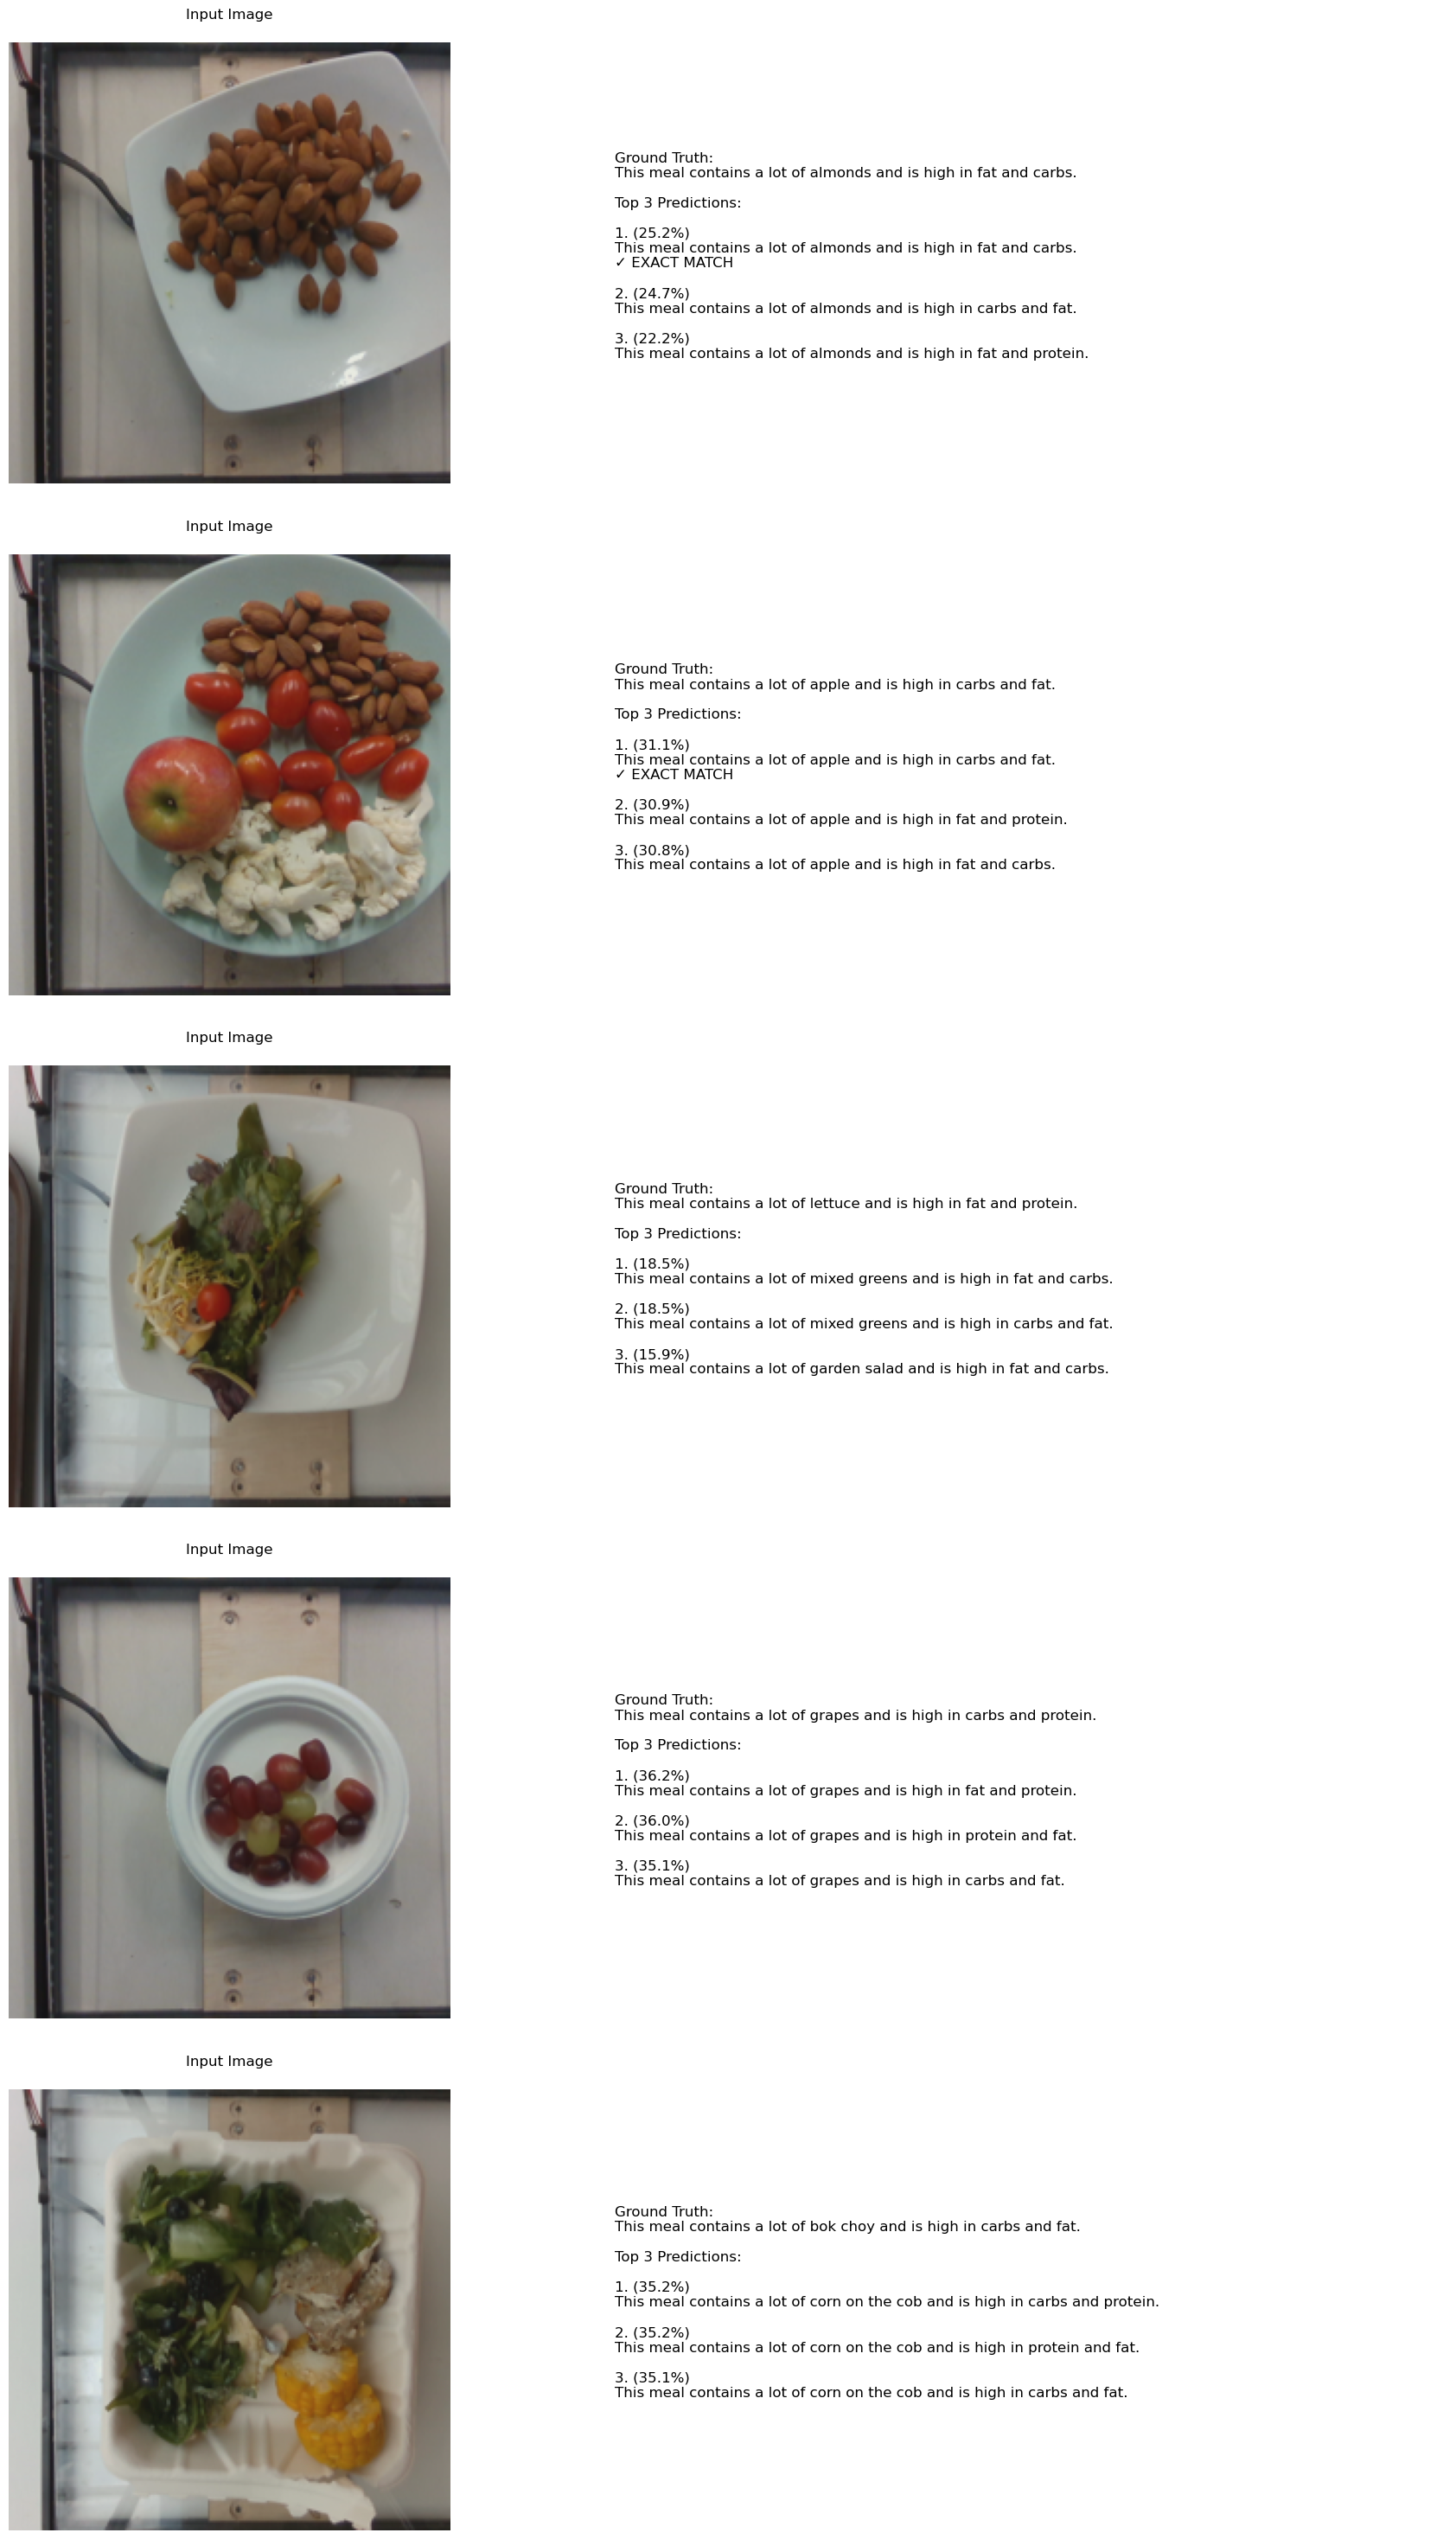

In [3]:
model, processor,metrics = train_model_with_early_stopping(epochs=50, batch_size=32)
config = Config()
train_df, val_df, test_df,_ = prepare_dataset(config)
train_loader, val_loader, test_loader = create_data_loaders(train_df, val_df, test_df, processor, batch_size=32)
    
# Evaluate and visualize
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
accuracy = evaluate_model(model, test_loader, processor, device)
visualize_predictions(model, test_loader, processor, device)

In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import traceback
import time

try:
    from transformers import get_cosine_schedule_with_warmup
    USE_TRANSFORMERS = True
except ImportError:
    USE_TRANSFORMERS = False
    print("Warning: transformers library not found. Using PyTorch's CosineAnnealingLR instead.")

#fine tune model

def train_model_with_improvements(epochs, batch_size, patience=10):
    config = Config()
    
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Using device: {device}")

    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    
    # Model setup with weight initialization
    clip_model = CLIPModel.from_pretrained(config.model_name)
    processor = CLIPProcessor.from_pretrained(config.model_name)
    model = SimilarityFoodCLIPModel(clip_model).to(device)
    
    # Improved optimizer with weight decay and learning rate scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    # Data setup with augmentation
    train_df, val_df, test_df, all_possible_descriptions = prepare_dataset(config)
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0))
    ])

    
    # Learning rate scheduler with warm-up
    total_steps = epochs * (train_df.shape[0] // batch_size)
    
    if USE_TRANSFORMERS:
        # Use transformers' scheduler with warmup if available
        warmup_steps = total_steps // 10
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
    else:
        # Fallback to PyTorch's CosineAnnealingLR
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=total_steps,
            eta_min=config.learning_rate * 0.01  # Minimum learning rate will be 1% of initial rate
        )
    
    
    
    train_loader, val_loader, test_loader = create_data_loaders(
        train_df, val_df, test_df, processor, batch_size,
    )

    # 5. Text features caching
    text_inputs = processor(
        text=all_possible_descriptions,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    # 6. Enhanced training tracking
    best_val_loss = float('inf')
    best_val_acc = 0.0
    metrics = {
        'train_losses': [], 'val_losses': [],
        'train_ingr_acc': [], 'val_ingr_acc': [],
        'train_nutr_acc': [], 'val_nutr_acc': [],
        'train_overall_acc': [], 'val_overall_acc': [],
        'learning_rates': []
    }
    no_improvement_epochs = 0

    # 7. Training loop with error handling and logging
    try:
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            epoch_start_time = time.time()
            
            # Training phase
            model.train()
            train_loss = 0
            epoch_train_metrics = {'ingredient_accuracy': 0, 'nutrient_accuracy': 0, 'overall_accuracy': 0}
            train_batches = 0

            # Cache text features
            with torch.no_grad():
                all_text_features = model.get_text_features(text_inputs)
            
            # Progress bar for training
            train_pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
            for batch in train_pbar:
                images = batch["images"].to(device)
                actual_texts = batch["texts"]

                image_features = model.get_image_features(images)
        
                # Calculate similarities and loss
                logits = (image_features @ all_text_features.T) / model.temperature
                correct_indices = torch.tensor([
                    all_possible_descriptions.index(text) for text in actual_texts
                ]).to(device)
                loss = F.cross_entropy(logits, correct_indices)


                # Backward pass with gradient scaling
                optimizer.zero_grad()
                if scaler is not None:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()
                
                scheduler.step()
                
                train_loss += loss.item()
                
                # Calculate and update metrics
                with torch.no_grad():
                    pred_indices = logits.argmax(dim=1).cpu()
                    predicted_texts = [all_possible_descriptions[idx] for idx in pred_indices]
                    batch_metrics = calculate_batch_accuracy(predicted_texts, actual_texts)
                    for key in epoch_train_metrics:
                        epoch_train_metrics[key] += batch_metrics[key]
                    train_batches += 1
                
                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.6f}'
                })
            
            # Calculate epoch metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_train_metrics = {k: v / train_batches for k, v in epoch_train_metrics.items()}
            
            # Validation phase with enhanced monitoring
            model.eval()
            val_loss = 0
            epoch_val_metrics = {'ingredient_accuracy': 0, 'nutrient_accuracy': 0, 'overall_accuracy': 0}
            val_batches = 0
            
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc="Validation")
                for batch in val_pbar:
                    images = batch["images"].to(device)
                    actual_texts = batch["texts"]
                    
                    image_features = model.get_image_features(images)
                    logits = (image_features @ all_text_features.T) / model.temperature
                    correct_indices = torch.tensor([
                        all_possible_descriptions.index(text) for text in actual_texts
                    ]).to(device)
                    loss = F.cross_entropy(logits, correct_indices)
                    val_loss += loss.item()
                    
                    # Calculate accuracy
                    pred_indices = logits.argmax(dim=1).cpu()
                    predicted_texts = [all_possible_descriptions[idx] for idx in pred_indices]
                    batch_metrics = calculate_batch_accuracy(predicted_texts, actual_texts)
                    for key in epoch_val_metrics:
                        epoch_val_metrics[key] += batch_metrics[key]
                    val_batches += 1
                    
                    val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_val_loss = val_loss / len(val_loader)
            avg_val_metrics = {k: v / val_batches for k, v in epoch_val_metrics.items()}
            
            # Update metrics tracking
            metrics['train_losses'].append(avg_train_loss)
            metrics['val_losses'].append(avg_val_loss)
            metrics['train_ingr_acc'].append(avg_train_metrics['ingredient_accuracy'])
            metrics['val_ingr_acc'].append(avg_val_metrics['ingredient_accuracy'])
            metrics['train_nutr_acc'].append(avg_train_metrics['nutrient_accuracy'])
            metrics['val_nutr_acc'].append(avg_val_metrics['nutrient_accuracy'])
            metrics['train_overall_acc'].append(avg_train_metrics['overall_accuracy'])
            metrics['val_overall_acc'].append(avg_val_metrics['overall_accuracy'])
            metrics['learning_rates'].append(scheduler.get_last_lr()[0])
            
            # 10. Enhanced logging and monitoring
            epoch_time = time.time() - epoch_start_time
            print(f"\nEpoch {epoch+1} Results (Time: {epoch_time:.2f}s):")
            print(f"Train - Loss: {avg_train_loss:.4f}")
            print(f"Train - Ingredient Acc: {avg_train_metrics['ingredient_accuracy']:.4f}")
            print(f"Train - Nutrient Acc: {avg_train_metrics['nutrient_accuracy']:.4f}")
            print(f"Train - Overall Acc: {avg_train_metrics['overall_accuracy']:.4f}")
            print(f"Val - Loss: {avg_val_loss:.4f}")
            print(f"Val - Ingredient Acc: {avg_val_metrics['ingredient_accuracy']:.4f}")
            print(f"Val - Nutrient Acc: {avg_val_metrics['nutrient_accuracy']:.4f}")
            print(f"Val - Overall Acc: {avg_val_metrics['overall_accuracy']:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
            
            # 11. Improved model checkpointing
            current_val_acc = avg_val_metrics['overall_accuracy']
            save_checkpoint = False
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                save_checkpoint = True
                print("New best validation loss!")
                
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                save_checkpoint = True
                print("New best validation accuracy!")
            
            if save_checkpoint:
                no_improvement_epochs = 0
                try:
                    checkpoint = {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'scaler_state_dict': scaler.state_dict() if scaler else None,
                        'best_val_loss': best_val_loss,
                        'best_val_acc': best_val_acc,
                        'metrics': metrics,
                        'all_possible_descriptions': all_possible_descriptions,
                        'config': config.__dict__
                    }
                    torch.save(checkpoint, config.save_path)
                    print(f"Saved checkpoint to {config.save_path}")
                except Exception as e:
                    print(f"Warning: Could not save checkpoint: {str(e)}")
            else:
                no_improvement_epochs += 1
                print(f"No improvement for {no_improvement_epochs} epoch(s)")
                if no_improvement_epochs >= patience:
                    print(f"Early stopping triggered. Best val loss: {best_val_loss:.4f}, Best val acc: {best_val_acc:.4f}")
                    break
                    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        traceback.print_exc()
    finally:
        if len(metrics['train_losses']) > 0:
            plot_training_curves(metrics)
            
    return model, processor, metrics

Using device: mps
Dataset splits:
Train set: 800 samples
Validation set: 100 samples
Test set: 100 samples
Number of unique ingredients: 117

Epoch 1/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, loss=5.7798]



Epoch 1 Results (Time: 19.06s):
Train - Loss: 6.0439
Train - Ingredient Acc: 0.3350
Train - Nutrient Acc: 0.3650
Train - Overall Acc: 0.3500
Val - Loss: 5.8785
Val - Ingredient Acc: 0.3594
Val - Nutrient Acc: 0.4375
Val - Overall Acc: 0.3984
Learning Rate: 0.000002
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 2/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, loss=5.1152]



Epoch 2 Results (Time: 18.99s):
Train - Loss: 5.5040
Train - Ingredient Acc: 0.4863
Train - Nutrient Acc: 0.4062
Train - Overall Acc: 0.4462
Val - Loss: 5.2659
Val - Ingredient Acc: 0.4766
Val - Nutrient Acc: 0.3828
Val - Overall Acc: 0.4297
Learning Rate: 0.000004
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 3/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, loss=4.7256]



Epoch 3 Results (Time: 18.60s):
Train - Loss: 4.8599
Train - Ingredient Acc: 0.6000
Train - Nutrient Acc: 0.4062
Train - Overall Acc: 0.5031
Val - Loss: 4.8661
Val - Ingredient Acc: 0.5000
Val - Nutrient Acc: 0.5078
Val - Overall Acc: 0.5039
Learning Rate: 0.000006
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 4/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, loss=4.2597]



Epoch 4 Results (Time: 18.78s):
Train - Loss: 4.2982
Train - Ingredient Acc: 0.7137
Train - Nutrient Acc: 0.3575
Train - Overall Acc: 0.5356
Val - Loss: 4.5970
Val - Ingredient Acc: 0.6406
Val - Nutrient Acc: 0.4922
Val - Overall Acc: 0.5664
Learning Rate: 0.000008
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 5/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, loss=4.0551]



Epoch 5 Results (Time: 18.48s):
Train - Loss: 3.8813
Train - Ingredient Acc: 0.7625
Train - Nutrient Acc: 0.3575
Train - Overall Acc: 0.5600
Val - Loss: 4.4815
Val - Ingredient Acc: 0.6328
Val - Nutrient Acc: 0.5000
Val - Overall Acc: 0.5664
Learning Rate: 0.000010
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 6/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, loss=4.1496]



Epoch 6 Results (Time: 18.68s):
Train - Loss: 3.6156
Train - Ingredient Acc: 0.8113
Train - Nutrient Acc: 0.3463
Train - Overall Acc: 0.5787
Val - Loss: 4.3812
Val - Ingredient Acc: 0.5234
Val - Nutrient Acc: 0.5312
Val - Overall Acc: 0.5273
Learning Rate: 0.000010
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 7/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s, loss=3.9625]



Epoch 7 Results (Time: 19.06s):
Train - Loss: 3.4263
Train - Ingredient Acc: 0.8413
Train - Nutrient Acc: 0.3812
Train - Overall Acc: 0.6112
Val - Loss: 4.3606
Val - Ingredient Acc: 0.5859
Val - Nutrient Acc: 0.5078
Val - Overall Acc: 0.5469
Learning Rate: 0.000010
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 8/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, loss=3.6198]



Epoch 8 Results (Time: 18.11s):
Train - Loss: 3.3018
Train - Ingredient Acc: 0.8588
Train - Nutrient Acc: 0.3850
Train - Overall Acc: 0.6219
Val - Loss: 4.2276
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.5234
Val - Overall Acc: 0.5859
Learning Rate: 0.000010
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 9/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, loss=3.5863]



Epoch 9 Results (Time: 18.10s):
Train - Loss: 3.2004
Train - Ingredient Acc: 0.8700
Train - Nutrient Acc: 0.3837
Train - Overall Acc: 0.6269
Val - Loss: 4.2252
Val - Ingredient Acc: 0.5938
Val - Nutrient Acc: 0.4453
Val - Overall Acc: 0.5195
Learning Rate: 0.000010
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 10/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, loss=3.4652]



Epoch 10 Results (Time: 27.72s):
Train - Loss: 3.1315
Train - Ingredient Acc: 0.8950
Train - Nutrient Acc: 0.4150
Train - Overall Acc: 0.6550
Val - Loss: 4.1418
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.5625
Val - Overall Acc: 0.6055
Learning Rate: 0.000010
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 11/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, loss=3.4335]



Epoch 11 Results (Time: 19.08s):
Train - Loss: 3.0767
Train - Ingredient Acc: 0.9187
Train - Nutrient Acc: 0.4175
Train - Overall Acc: 0.6681
Val - Loss: 4.1270
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.5547
Val - Overall Acc: 0.6055
Learning Rate: 0.000010
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 12/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, loss=3.4875]



Epoch 12 Results (Time: 19.02s):
Train - Loss: 3.0386
Train - Ingredient Acc: 0.9350
Train - Nutrient Acc: 0.4250
Train - Overall Acc: 0.6800
Val - Loss: 4.1076
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.6211
Learning Rate: 0.000009
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 13/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, loss=3.4250]



Epoch 13 Results (Time: 18.99s):
Train - Loss: 3.0039
Train - Ingredient Acc: 0.9437
Train - Nutrient Acc: 0.4525
Train - Overall Acc: 0.6981
Val - Loss: 4.1098
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.5469
Val - Overall Acc: 0.6016
Learning Rate: 0.000009
No improvement for 1 epoch(s)

Epoch 14/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, loss=3.4984]



Epoch 14 Results (Time: 18.50s):
Train - Loss: 2.9730
Train - Ingredient Acc: 0.9637
Train - Nutrient Acc: 0.4550
Train - Overall Acc: 0.7094
Val - Loss: 4.1508
Val - Ingredient Acc: 0.6484
Val - Nutrient Acc: 0.5625
Val - Overall Acc: 0.6055
Learning Rate: 0.000009
No improvement for 2 epoch(s)

Epoch 15/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, loss=3.4284]



Epoch 15 Results (Time: 18.39s):
Train - Loss: 2.9448
Train - Ingredient Acc: 0.9663
Train - Nutrient Acc: 0.4612
Train - Overall Acc: 0.7137
Val - Loss: 4.0923
Val - Ingredient Acc: 0.6719
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.6250
Learning Rate: 0.000009
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 16/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, loss=3.4681]



Epoch 16 Results (Time: 18.64s):
Train - Loss: 2.9204
Train - Ingredient Acc: 0.9750
Train - Nutrient Acc: 0.4838
Train - Overall Acc: 0.7294
Val - Loss: 4.0900
Val - Ingredient Acc: 0.6875
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.6328
Learning Rate: 0.000009
New best validation loss!
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 17/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, loss=3.4392]



Epoch 17 Results (Time: 19.08s):
Train - Loss: 2.9002
Train - Ingredient Acc: 0.9800
Train - Nutrient Acc: 0.4988
Train - Overall Acc: 0.7394
Val - Loss: 4.0829
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.5625
Val - Overall Acc: 0.5820
Learning Rate: 0.000008
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 18/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, loss=3.3863]



Epoch 18 Results (Time: 19.04s):
Train - Loss: 2.8817
Train - Ingredient Acc: 0.9812
Train - Nutrient Acc: 0.5038
Train - Overall Acc: 0.7425
Val - Loss: 4.0799
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.6211
Learning Rate: 0.000008
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 19/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, loss=3.4205]



Epoch 19 Results (Time: 18.96s):
Train - Loss: 2.8645
Train - Ingredient Acc: 0.9800
Train - Nutrient Acc: 0.5425
Train - Overall Acc: 0.7612
Val - Loss: 4.0826
Val - Ingredient Acc: 0.6562
Val - Nutrient Acc: 0.5859
Val - Overall Acc: 0.6211
Learning Rate: 0.000008
No improvement for 1 epoch(s)

Epoch 20/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, loss=3.3583]



Epoch 20 Results (Time: 18.60s):
Train - Loss: 2.8506
Train - Ingredient Acc: 0.9825
Train - Nutrient Acc: 0.5537
Train - Overall Acc: 0.7681
Val - Loss: 4.0601
Val - Ingredient Acc: 0.6719
Val - Nutrient Acc: 0.5781
Val - Overall Acc: 0.6250
Learning Rate: 0.000008
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 21/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, loss=3.3976]



Epoch 21 Results (Time: 19.26s):
Train - Loss: 2.8396
Train - Ingredient Acc: 0.9912
Train - Nutrient Acc: 0.5600
Train - Overall Acc: 0.7756
Val - Loss: 4.0715
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.6016
Val - Overall Acc: 0.6328
Learning Rate: 0.000007
No improvement for 1 epoch(s)

Epoch 22/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, loss=3.4829]



Epoch 22 Results (Time: 19.35s):
Train - Loss: 2.8306
Train - Ingredient Acc: 0.9888
Train - Nutrient Acc: 0.5813
Train - Overall Acc: 0.7850
Val - Loss: 4.0850
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5859
Val - Overall Acc: 0.6250
Learning Rate: 0.000007
No improvement for 2 epoch(s)

Epoch 23/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, loss=3.4289]



Epoch 23 Results (Time: 18.66s):
Train - Loss: 2.8226
Train - Ingredient Acc: 0.9962
Train - Nutrient Acc: 0.5787
Train - Overall Acc: 0.7875
Val - Loss: 4.0928
Val - Ingredient Acc: 0.6719
Val - Nutrient Acc: 0.6094
Val - Overall Acc: 0.6406
Learning Rate: 0.000007
New best validation accuracy!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 24/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s, loss=3.3827]



Epoch 24 Results (Time: 19.29s):
Train - Loss: 2.8160
Train - Ingredient Acc: 0.9962
Train - Nutrient Acc: 0.5950
Train - Overall Acc: 0.7956
Val - Loss: 4.0533
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.5859
Val - Overall Acc: 0.6250
Learning Rate: 0.000006
New best validation loss!
Saved checkpoint to model_checkpoints/food_clip_model.pt

Epoch 25/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s, loss=3.4577]



Epoch 25 Results (Time: 19.03s):
Train - Loss: 2.8091
Train - Ingredient Acc: 0.9938
Train - Nutrient Acc: 0.5887
Train - Overall Acc: 0.7913
Val - Loss: 4.0893
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.6094
Val - Overall Acc: 0.6055
Learning Rate: 0.000006
No improvement for 1 epoch(s)

Epoch 26/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s, loss=3.4437]



Epoch 26 Results (Time: 19.12s):
Train - Loss: 2.8021
Train - Ingredient Acc: 0.9975
Train - Nutrient Acc: 0.5962
Train - Overall Acc: 0.7969
Val - Loss: 4.0573
Val - Ingredient Acc: 0.6641
Val - Nutrient Acc: 0.6094
Val - Overall Acc: 0.6367
Learning Rate: 0.000006
No improvement for 2 epoch(s)

Epoch 27/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, loss=3.4909]



Epoch 27 Results (Time: 19.42s):
Train - Loss: 2.7964
Train - Ingredient Acc: 0.9975
Train - Nutrient Acc: 0.6050
Train - Overall Acc: 0.8013
Val - Loss: 4.0936
Val - Ingredient Acc: 0.6094
Val - Nutrient Acc: 0.6328
Val - Overall Acc: 0.6211
Learning Rate: 0.000005
No improvement for 3 epoch(s)

Epoch 28/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s, loss=3.5134]



Epoch 28 Results (Time: 19.18s):
Train - Loss: 2.7918
Train - Ingredient Acc: 0.9988
Train - Nutrient Acc: 0.6138
Train - Overall Acc: 0.8063
Val - Loss: 4.0875
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.5391
Val - Overall Acc: 0.5703
Learning Rate: 0.000005
No improvement for 4 epoch(s)

Epoch 29/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, loss=3.4694]



Epoch 29 Results (Time: 19.20s):
Train - Loss: 2.7877
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6138
Train - Overall Acc: 0.8069
Val - Loss: 4.0797
Val - Ingredient Acc: 0.6172
Val - Nutrient Acc: 0.6094
Val - Overall Acc: 0.6133
Learning Rate: 0.000004
No improvement for 5 epoch(s)

Epoch 30/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, loss=3.4453]



Epoch 30 Results (Time: 18.75s):
Train - Loss: 2.7840
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6138
Train - Overall Acc: 0.8069
Val - Loss: 4.0811
Val - Ingredient Acc: 0.5938
Val - Nutrient Acc: 0.6250
Val - Overall Acc: 0.6094
Learning Rate: 0.000004
No improvement for 6 epoch(s)

Epoch 31/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, loss=3.5000]



Epoch 31 Results (Time: 18.86s):
Train - Loss: 2.7810
Train - Ingredient Acc: 0.9975
Train - Nutrient Acc: 0.6250
Train - Overall Acc: 0.8113
Val - Loss: 4.0928
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.5547
Val - Overall Acc: 0.5781
Learning Rate: 0.000004
No improvement for 7 epoch(s)

Epoch 32/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, loss=3.4669]



Epoch 32 Results (Time: 18.69s):
Train - Loss: 2.7782
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6250
Train - Overall Acc: 0.8125
Val - Loss: 4.0854
Val - Ingredient Acc: 0.6016
Val - Nutrient Acc: 0.6250
Val - Overall Acc: 0.6133
Learning Rate: 0.000003
No improvement for 8 epoch(s)

Epoch 33/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, loss=3.5063]



Epoch 33 Results (Time: 18.84s):
Train - Loss: 2.7757
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6250
Train - Overall Acc: 0.8125
Val - Loss: 4.0934
Val - Ingredient Acc: 0.5938
Val - Nutrient Acc: 0.5469
Val - Overall Acc: 0.5703
Learning Rate: 0.000003
No improvement for 9 epoch(s)

Epoch 34/50


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, loss=3.4780]



Epoch 34 Results (Time: 18.83s):
Train - Loss: 2.7733
Train - Ingredient Acc: 1.0000
Train - Nutrient Acc: 0.6350
Train - Overall Acc: 0.8175
Val - Loss: 4.0832
Val - Ingredient Acc: 0.6094
Val - Nutrient Acc: 0.5469
Val - Overall Acc: 0.5781
Learning Rate: 0.000003
No improvement for 10 epoch(s)
Early stopping triggered. Best val loss: 4.0533, Best val acc: 0.6406


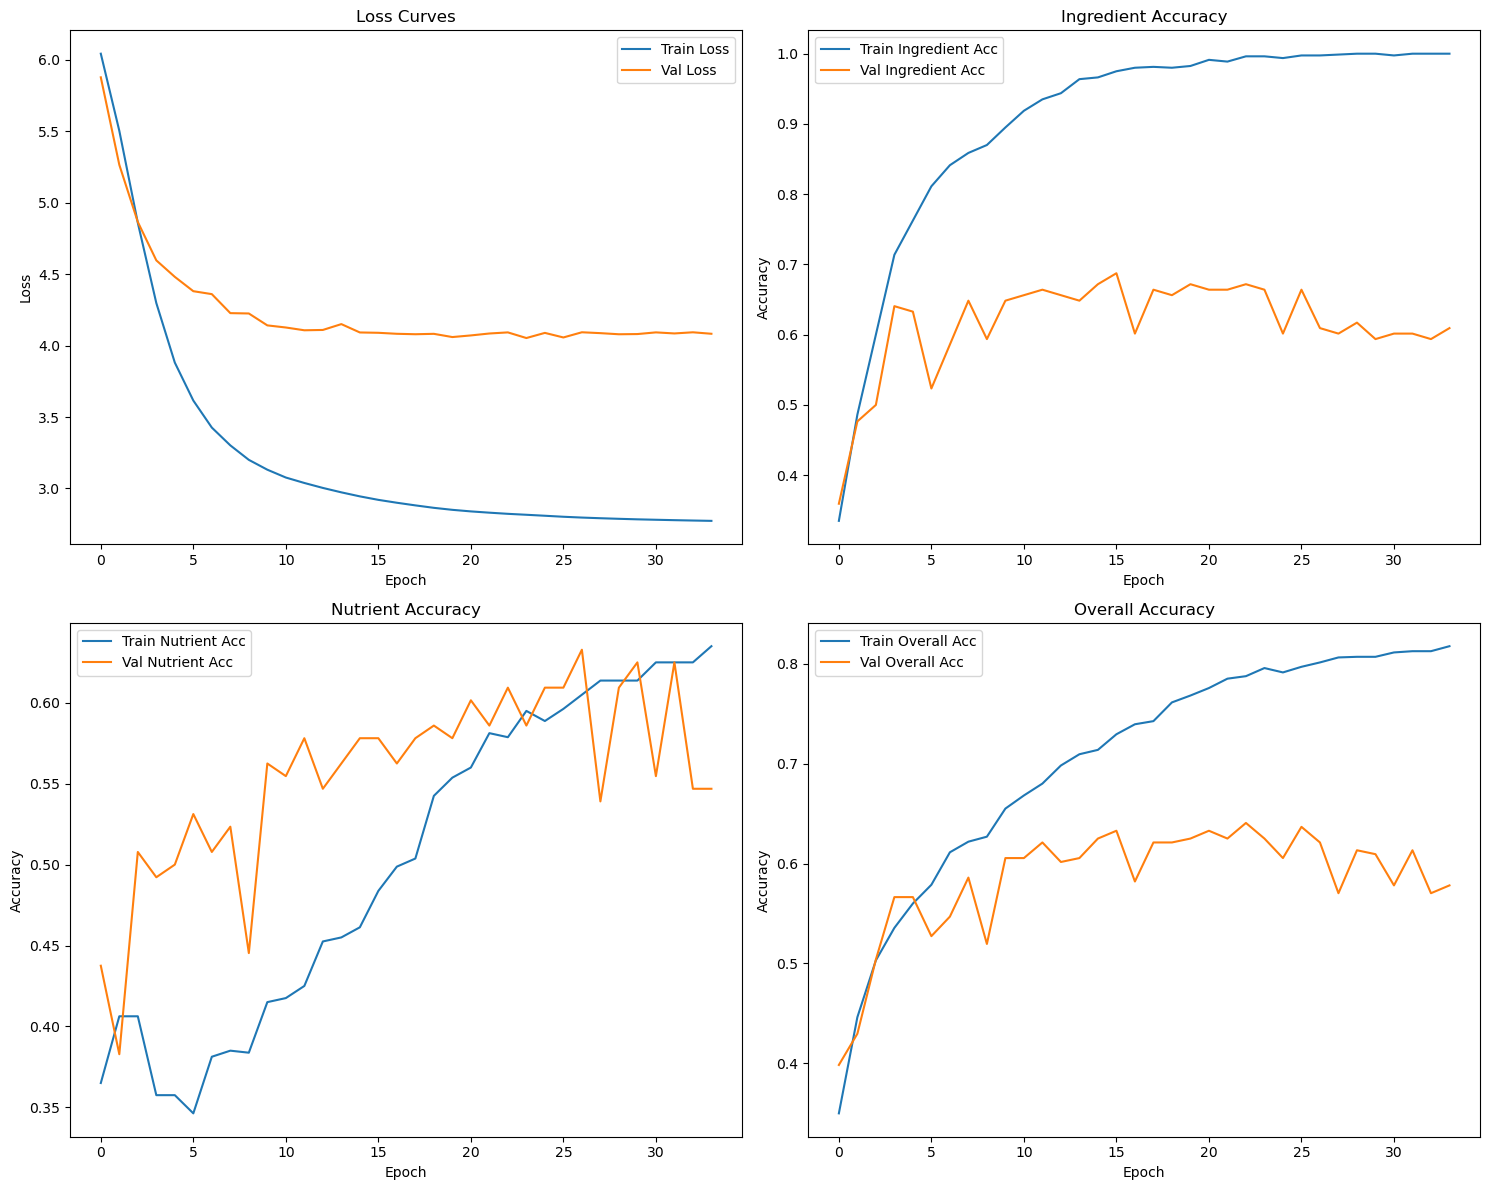

In [20]:
model2,processor2,metrics2 = train_model_with_improvements(epochs = 50, batch_size =32, patience=10)

Dataset splits:
Train set: 800 samples
Validation set: 100 samples
Test set: 100 samples
Number of unique ingredients: 117


/var/folders/fk/gj43ql8172g1p_322ps4bc440000gn/T/ipykernel_30895/2626997339.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.save_path)
T


Test Results:
Test Loss: 4.0385
Ingredient Accuracy: 0.6400
Nutrient Accuracy: 0.5100
Overall Accuracy: 0.5750

Top 5 Ingredient Mistakes:
Actual: sweet potato, Predicted: roasted potatoes, Count: 4
Error Rate: 4.00%
Actual: pork, Predicted: chicken thighs, Count: 2
Error Rate: 2.00%
Actual: chicken, Predicted: chicken thighs, Count: 1
Error Rate: 1.00%
Actual: steak, Predicted: pork, Count: 1
Error Rate: 1.00%
Actual: chicken breast, Predicted: grilled chicken, Count: 1
Error Rate: 1.00%

Top 5 Nutrient Pair Mistakes:
Actual: carbs and protein, Predicted: fat and protein, Count: 26
Error Rate: 26.00%
Actual: carbs and protein, Predicted: carbs and fat, Count: 10
Error Rate: 10.00%
Actual: carbs and fat, Predicted: fat and protein, Count: 8
Error Rate: 8.00%
Actual: carbs and fat, Predicted: carbs and protein, Count: 3
Error Rate: 3.00%
Actual: fat and protein, Predicted: carbs and fat, Count: 1
Error Rate: 1.00%

Detailed analysis saved to test_analysis.json


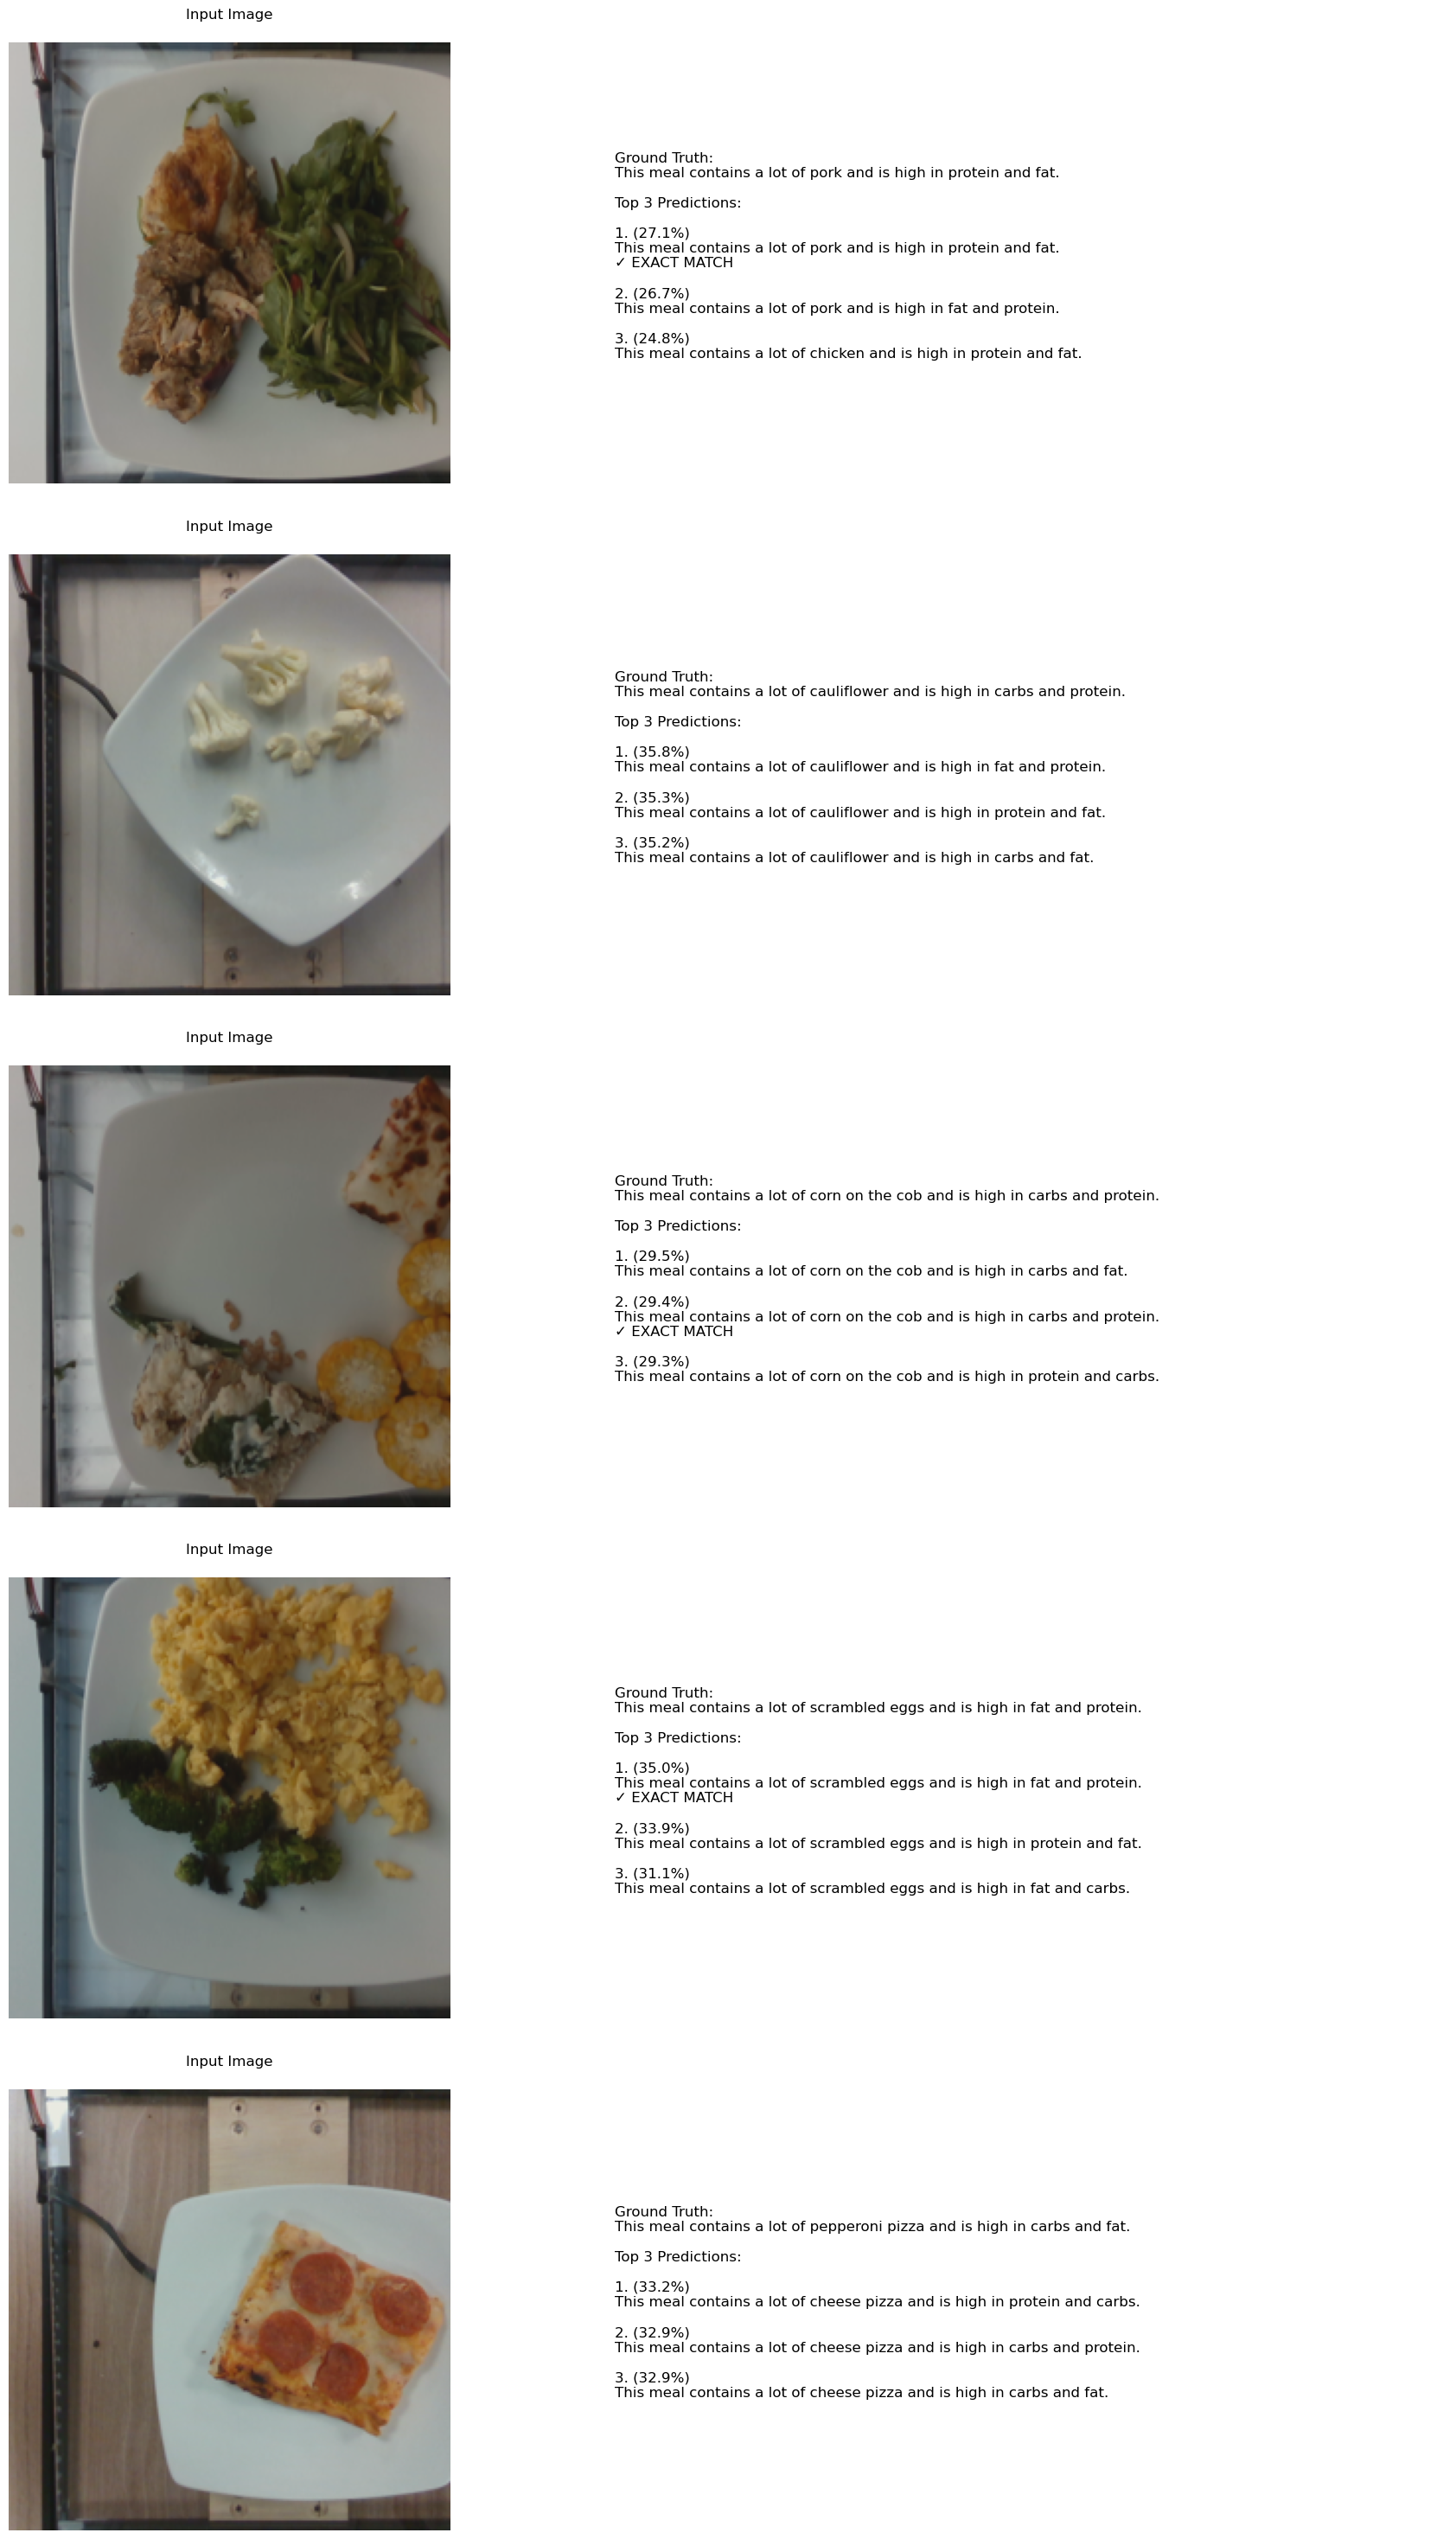

In [22]:
config = Config()
train_df, val_df, test_df,_ = prepare_dataset(config)
train_loader, val_loader, test_loader = create_data_loaders(train_df, val_df, test_df, processor2, batch_size=32)
    
# Evaluate and visualize
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
accuracy = evaluate_model(model2, test_loader, processor2, device)
visualize_predictions(model2, test_loader, processor2, device)